In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import gensim
from gensim.models import CoherenceModel

%matplotlib inline

pd.options.display.precision = 15
pd.options.display.max_rows = 500

In [2]:
df = pd.read_csv('Output\Mid_Data_Processed.csv')
corpus = df['description']

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

corpus = df['description']
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(corpus)

#Dataframe with cosine similarties
cos_df = pd.DataFrame(cosine_similarity(X_train_counts))

#Dataframe for job advert and similarity with every other advert
i, j = np.indices(cos_df.shape).reshape(2, -1)
cos_values = cos_df.values.reshape(-1)
cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'sim':cos_values})

#Any advert that has a cosine similarity above 0.98 and doesn't equal itself
cos_rem = cos_sim_df[(cos_sim_df['sim']>0.98)&(i!=j)]

#Method to remove duplicates but keep first instance. Trying to drop duplicates on i and j column wouldn't work as the numbers don't duplicate in those
#columns. Setting another column that combines their values ensure that duplicates can be dropped.

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

#Drop from original dataframe
df = df[~df.index.isin(drop_rows)]
df = df.reset_index()
df.drop(columns={'index'}, inplace=True)

C:\Users\Test\AppData\Local\Temp\ipykernel_16572\452536419.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']


In [4]:
corpus = df['description']

In [5]:
import nltk 
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

#Function to pre-process the text information

def normalize_document(doc):
    
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I (ignore case), re.A (ASCII-only matching)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatise document from filtered tokens
    lem_text = [lemmatizer.lemmatize(i) for i in filtered_tokens]
    
    # Remove words that are only one character.
    lem_text = [token for token in lem_text if len(token) > 1]
    
    # Remove numbers, but not words that contain numbers.
    lem_text = [token for token in lem_text if not token.isnumeric()]
    
    doc = ' '.join(lem_text)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)

In [6]:
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import gensim.corpora as corpora

#Tokenise the corpus
tokenized_corp = [word_tokenize(i) for i in norm_corpus]

# Create Dictionary
id2word = corpora.Dictionary(tokenized_corp)

#Remove words that don't feature 20 times and those that feature in over 50% of documents
id2word.filter_extremes(no_below=20, no_above=0.5)

texts = tokenized_corp

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [7]:
def compute_coherence_values(corpus, dictionary, texts, end, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, end, step):
    
        # Build LDA model
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               random_state=123,
                                               chunksize=100,
                                               passes=500, #number of passes was investigated. At 500 the coherence score will remain relatively similar
                                               #with any further increase. As the document is quite small this number of passes makes sense.
                                               per_word_topics=True)
        model_list.append(lda_model)
        
        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values

In [8]:
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary = id2word, texts=texts, start=1, end=20, step=1)

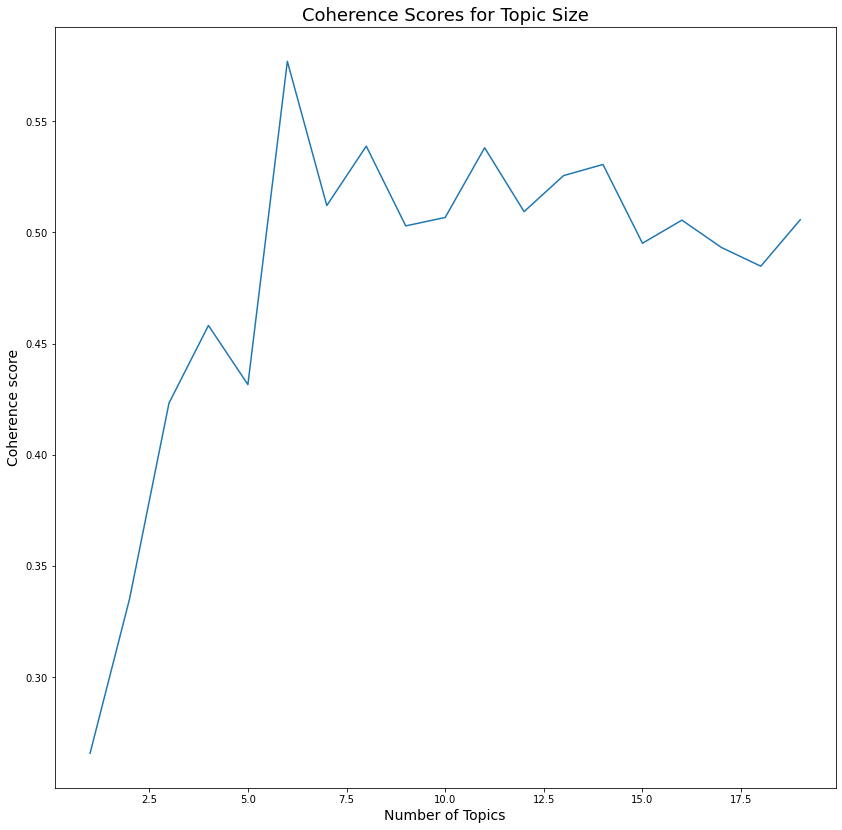

In [9]:
# Show graph
end=20; start=1; step=1;
x = range(start, end, step)
ax = plt.subplots(figsize=(14,14))
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
plt.title('Coherence Scores for Topic Size', fontsize=18)
plt.show();

In [10]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=123,
                                       chunksize=100,
                                       passes=500,
                                       per_word_topics=True)

In [11]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5769527826835107


In [12]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"product" + 0.014*"insight" + 0.012*"marketing" + 0.012*"customer" + '
  '0.009*"across" + 0.007*"digital" + 0.007*"stakeholder" + 0.007*"key" + '
  '0.006*"drive" + 0.006*"user"'),
 (1,
  '0.070*")" + 0.035*"(" + 0.030*":" + 0.028*"line" + 0.027*"//" + '
  '0.023*"福利厚生" + 0.022*"）、" + 0.021*"http" + 0.018*"スキル" + 0.018*"給与"'),
 (2,
  '0.013*"report" + 0.011*"using" + 0.010*"analytical" + 0.010*"information" + '
  '0.010*"science" + 0.010*"bi" + 0.009*"database" + 0.009*"insight" + '
  '0.009*"reporting" + 0.009*"ability"'),
 (3,
  '0.012*"company" + 0.011*"global" + 0.010*"technology" + 0.010*"market" + '
  '0.008*"singapore" + 0.007*"opportunity" + 0.007*"career" + '
  '0.006*"development" + 0.006*"people" + 0.006*"world"'),
 (4,
  '0.013*"opportunity" + 0.011*"status" + 0.009*"employee" + '
  '0.008*"disability" + 0.008*"gender" + 0.008*"health" + 0.007*"company" + '
  '0.007*"equal" + 0.007*"employment" + 0.007*"employer"'),
 (5,
  '0.019*"management" + 0.017*"process

In [13]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

c:\Users\Test\miniconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=                       x                  y  topics  cluster  \
topic                                                          
2     -0.097233019717742 -0.145915481363845       1        1   
4     -0.029374684473286  0.188519483833084       2        1   
0     -0.091797411884332 -0.024334220595299       3        1   
5     -0.109359467073029 -0.076712421893282       4        1   
3     -0.071528019381622  0.090499146422173       5        1   
1      0.399292602530012 -0.032056506402833       6        1   

                     Freq  
topic                      
2      22.882434588672069  
4      22.288450123072124  
0      21.120447523411034  
5      20.527347943440610  
3      11.891804277209603  
1       1.289515544194558  , topic_info=                       Term                  Freq                 Total  \
439                 product  1319.000000000000000  1319.000000000000000   
16                   python   563.000000000000000   563.000000000000000   
92               employment   358.000000000000000   358.000000000000000   
206                 benefit   351.000000000000000   351.000000000000000   
20                        )   181.000000000000000   181.000000000000000   
192                  status   519.000000000000000   519.000000000000000   
756               marketing   525.000000000000000   525.000000000000000   
115                 insight  1070.000000000000000  1070.000000000000000   
1129                   line   177.000000000000000   177.000000000000000   
362                  career   380.000000000000000   380.000000000000000   
117                     job   762.000000000000000   762.000000000000000   
23                       bi   563.000000000000000   563.000000000000000   
136                 process  1219.000000000000000  1219.000000000000000   
328                  system   982.000000000000000   982.000000000000000   
87               disability   365.000000000000000   365.000000000000000   
418              management  1314.000000000000000  1314.000000000000000   
18                  tableau   465.000000000000000   465.000000000000000   
235                employee   493.000000000000000   493.000000000000000   
102                  gender   341.000000000000000   341.000000000000000   
80                 customer   943.000000000000000   943.000000000000000   
95                    equal   328.000000000000000   328.000000000000000   
217                 company   981.000000000000000   981.000000000000000   
520                  market   425.000000000000000   425.000000000000000   
104                  global   570.000000000000000   570.000000000000000   
764                position   412.000000000000000   412.000000000000000   
594                  health   361.000000000000000   361.000000000000000   
91                 employer   317.000000000000000   317.000000000000000   
165             statistical   465.000000000000000   465.000000000000000   
1661                      (    91.000000000000000    91.000000000000000   
37                   google   269.000000000000000   269.000000000000000   
107                  hadoop    60.409738378951218    61.257796046742889   
544               secondary    44.450155982090088    45.300531800753355   
1548                 locate    40.419838097529677    41.265108911887658   
1686                 shopee    34.465932898847690    35.314830202709175   
810             disseminate    33.981700794767818    34.827211575548752   
830            mathematical    27.837412009649995    28.685905151400899   
1643            aggregation    26.672175217522575    27.521443142209751   
1454  requirementsbachelors    20.825943575407070    21.674427508857686   
1638                rakuten    95.491355538281866    99.595957014565045   
388                     etl   177.863862727656425   189.746941934628865   
1465            exploration    25.046508939939599    26.918237690702711   
26               javascript    28.462508966162542    30.82630727570874